In [5]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBRegressor, XGBClassifier
import matplotlib.pyplot as plt



In [18]:
# 加載數據
data = pd.read_csv('2023_09_2024_08_AQI_Weather_dataset.csv')

data.rename(columns={
    '測站氣壓(hPa)': 'station_pressure_hpa',
    '氣溫(℃)': 'temperature_c',
    '相對溼度(%)': 'relative_humidity',
    '風速(m/s)': 'wind_speed_m_s',
    '風向(360degree)': 'wind_direction_deg',
    #'最大瞬間風(m/s)': 'max_instant_wind_m_s',
    #'最大瞬間風風向(360degree)': 'max_instant_wind_direction_deg',
    '降水量(mm)': 'precipitation_mm'
}, inplace=True)

# 選擇需要的欄位
features = ['station_pressure_hpa', 'temperature_c', 'relative_humidity', 'wind_speed_m_s',
    'wind_direction_deg', 
    'precipitation_mm', 'pm2.5', 'pm10', 'so2', 'no2', 'nox', 'o3', 'co', 'o3_8hr',
    'co_8hr', 'pm2.5_avg', 'pm10_avg', 'so2_avg', 'no']
target = 'aqi'

# 將 AQI 轉為分級
def map_aqi_to_label(aqi):
    if aqi <= 50:
        return 0  # 良好
    elif aqi <= 100:
        return 1  # 普通
    elif aqi <= 150:
        return 2  # 對敏感族群不健康
    elif aqi <= 200:
        return 3  # 對所有族群不健康
    elif aqi <= 300:
        return 4  # 非常不健康
    else:
        return 5  # 危害

# 定義函數來計算分類指標
def calculate_classification_metrics(y_true, y_pred, label=""):
    # 將連續值轉換為分類標籤
    y_true_labels = np.array([map_aqi_to_label(aqi) for aqi in y_true.ravel()])
    y_pred_labels = np.array([map_aqi_to_label(aqi) for aqi in y_pred.ravel()])
    
    # 計算分類指標
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    recall = recall_score(y_true_labels, y_pred_labels, average="macro")
    f1 = f1_score(y_true_labels, y_pred_labels, average="macro")
    #auroc = roc_auc_score(y_true_labels, y_pred_labels)
    
    print(f"{label} Accuracy: {accuracy:.3f}")
    print(f"{label} Recall (Macro): {recall:.3f}")
    print(f"{label} F1-Score (Macro): {f1:.3f}")
    #print(f"{label} AUROC: {auroc:.3f}")

# 滑動窗口生成器
def create_windowed_data_all(data, features, target, input_steps, output_steps):
    X = []
    y = []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[features].iloc[i:i + input_steps].values.astype('float32'))
        y.append(data[target].iloc[i + input_steps:i + input_steps + output_steps].values.astype('float32'))
    return np.array(X), np.array(y)

def plot_feature_importance(model, feature_names, top_n=10):
    """
    繪製特徵重要性圖。
    Args:
        model: 訓練後的 XGBoost 模型。
        feature_names: 特徵名稱列表。
        top_n: 顯示的特徵數量。
    """
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    }).sort_values(by="importance", ascending=False).head(top_n)
    
    # 繪圖
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["feature"], importance_df["importance"], color="skyblue")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"Top {top_n} Feature Importance")
    plt.gca().invert_yaxis()  # 翻轉 Y 軸，重要特徵在頂部
    plt.show()
    
    return importance_df


In [7]:
data

,datacreationdate,sitename,aqi,so2,co,o3,o3_8hr,pm10,pm2.5,no2,...,co_8hr,pm2.5_avg,pm10_avg,so2_avg,station_pressure_hpa,temperature_c,relative_humidity,wind_speed_m_s,wind_direction_deg,precipitation_mm
0,2023-09-01 01:00:00,三重,27.0,0.9,0.60,8.6,8.8,15.0,8.0,13.3,...,0.6,7.6,15.0,0.0,1002.3,27.7,92.0,1.9,69.0,2.0
1,2023-09-01 02:00:00,三重,26.0,0.9,0.60,8.4,8.8,15.0,7.0,13.2,...,0.6,7.6,15.0,0.0,1001.1,28.0,90.0,3.4,57.0,0.0
2,2023-09-01 03:00:00,三重,26.0,0.8,0.60,8.2,8.7,15.0,7.0,13.2,...,0.6,7.5,15.0,0.0,1001.2,27.5,91.0,4.4,90.0,0.5
3,2023-09-01 04:00:00,三重,26.0,0.8,0.60,8.0,8.6,15.0,7.0,13.1,...,0.6,7.4,15.0,0.0,1001.3,27.2,91.0,5.4,73.0,0.0
4,2023-09-01 05:00:00,三重,26.0,0.8,0.60,7.9,8.5,15.0,7.0,13.0,...,0.6,7.4,15.0,0.0,1001.4,27.3,88.0,3.9,68.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114187,2024-08-31 20:00:00,臺東,19.0,1.6,0.15,16.2,21.1,11.0,2.0,5.1,...,0.1,4.5,17.0,1.0,1008.4,27.8,75.0,2.4,324.0,0.0
114188,2024-08-31 21:00:00,臺東,19.0,1.4,0.17,16.3,20.1,14.0,4.0,3.8,...,0.1,4.2,18.0,1.0,1008.9,27.8,75.0,0.8,307.0,0.0
114189,2024-08-31 22:00:00,臺東,19.0,1.6,0.17,15.0,18.9,17.0,3.0,7.0,...,0.1,3.9,19.0,1.0,1009.2,27.4,74.0,1.0,333.0,0.0
114190,2024-08-31 23:00:00,臺東,19.0,1.6,0.13,16.4,18.2,12.0,2.0,5.0,...,0.1,3.8,19.0,1.0,1009.3,27.4,72.0,1.3,316.0,0.0


(114191, 1, 19)
(114191, 1)
XGB Fit time: 0.7155 seconds
XGB Predict time: 0.0170 seconds
XGBoost (Short-Term):
MSE: 13.850524
MAE: 2.251422
XGBoost (Short) Accuracy: 0.954
XGBoost (Short) Recall (Macro): 0.842
XGBoost (Short) F1-Score (Macro): 0.870


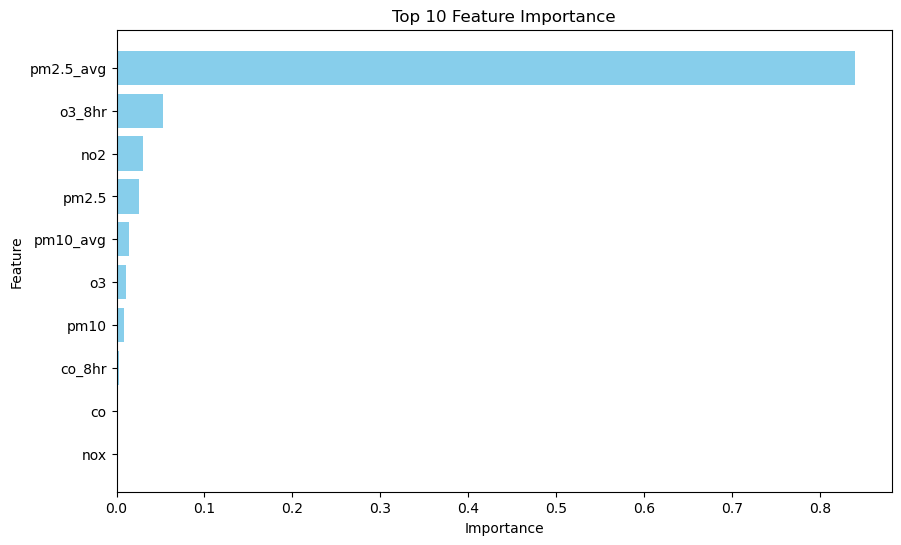

Top 10 Features:
      feature  importance
15  pm2.5_avg    0.839139
13     o3_8hr    0.052943
9         no2    0.030282
6       pm2.5    0.025432
16   pm10_avg    0.013931
11         o3    0.011235
7        pm10    0.008667
14     co_8hr    0.002804
12         co    0.002242
10        nox    0.002198


In [8]:
# 初始化模型
xgb_short = XGBRegressor(random_state=42)

# 短期
X_short, y_short = create_windowed_data_all(data, features, target, input_steps=1, output_steps=1)
X_train_short, X_test_short, y_train_short, y_test_short= train_test_split(X_short, y_short, test_size=0.2, random_state=42)

print(X_short.shape)
print(y_short.shape)

# 訓練模型
X_train_flat_short = X_train_short.reshape(X_train_short.shape[0], -1)  # 展平特徵
start_time = time.time()
xgb_short.fit(X_train_flat_short, y_train_short)
fit_time = time.time() - start_time
print(f"XGB Fit time: {fit_time:.4f} seconds")


# 測試模型
X_test_flat_short = X_test_short.reshape(X_test_short.shape[0], -1)
start_time = time.time()
y_pred_xgb_short = xgb_short.predict(X_test_flat_short)
predict_time = time.time() - start_time
print(f"XGB Predict time: {predict_time:.4f} seconds")

# 評估
print("XGBoost (Short-Term):")
print("MSE:", mean_squared_error(y_test_short, y_pred_xgb_short))
print("MAE:", mean_absolute_error(y_test_short, y_pred_xgb_short))

calculate_classification_metrics(y_test_short, y_pred_xgb_short, "XGBoost (Short)")
# 繪製特徵重要性圖
top_10_features_1hr = plot_feature_importance(xgb_short, features, top_n=10)
print("Top 10 Features:")
print(top_10_features_1hr)


XGBClassifier Fit time: 1.9917 seconds
XGBClassifier Predict time: 0.0337 seconds

XGBClassifier (Short-Term):
Classification Report:
              precision    recall  f1-score   support

           0      0.968     0.969     0.968     12166
           1      0.948     0.948     0.948      9288
           2      0.912     0.919     0.916      1327
           3      0.829     0.586     0.687        58

    accuracy                          0.956     22839
   macro avg      0.914     0.855     0.880     22839
weighted avg      0.956     0.956     0.956     22839

XGBClassifier Accuracy: 0.956
XGBClassifier Recall (Macro): 0.855
XGBClassifier F1-Score (Macro): 0.880


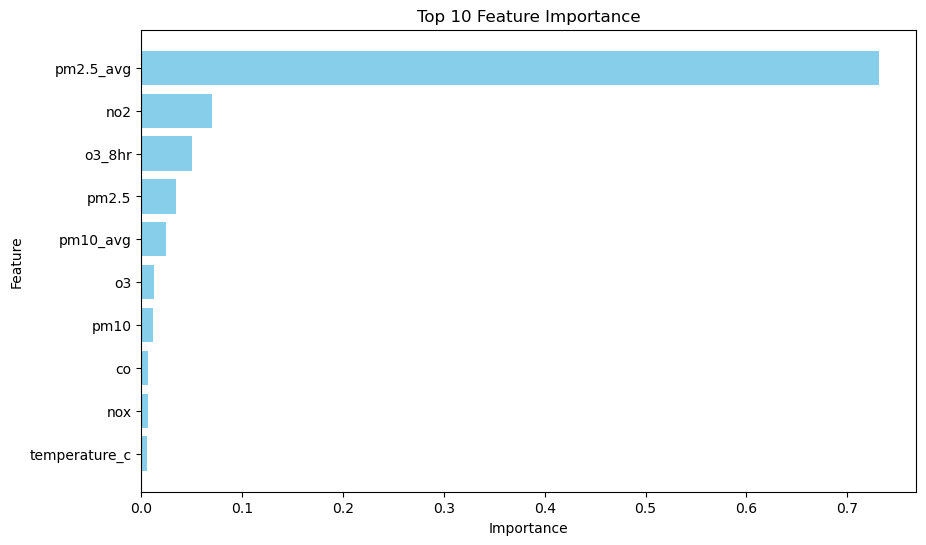

Top 10 Features (XGBClassifier):
          feature  importance
15      pm2.5_avg    0.732029
9             no2    0.069631
13         o3_8hr    0.050537
6           pm2.5    0.034338
16       pm10_avg    0.024407
11             o3    0.012652
7            pm10    0.011518
12             co    0.006151
10            nox    0.006085
1   temperature_c    0.005917


In [15]:
# Adding an XGBClassifier for classification results

# Initialize XGBClassifier
xgb_classifier = XGBClassifier(random_state=42)

# Prepare data for classification
y_short_class_labels = np.array([map_aqi_to_label(aqi) for aqi in y_short.ravel()])  # Map AQI values to labels
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_short.reshape(X_short.shape[0], -1), y_short_class_labels, test_size=0.2, random_state=42
)

# Train the classifier
start_time = time.time()
xgb_classifier.fit(X_train_class, y_train_class)
fit_time_class = time.time() - start_time
print(f"XGBClassifier Fit time: {fit_time_class:.4f} seconds")

# Predict using the classifier
start_time = time.time()
y_pred_class = xgb_classifier.predict(X_test_class)
predict_time_class = time.time() - start_time
print(f"XGBClassifier Predict time: {predict_time_class:.4f} seconds")

# Evaluate the classifier
print("\nXGBClassifier (Short-Term):")
print("Classification Report:")
print(classification_report(y_test_class, y_pred_class, digits=3))

# 計算分類指標
accuracy = accuracy_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class, average="macro")
f1 = f1_score(y_test_class, y_pred_class, average="macro")

print(f"XGBClassifier Accuracy: {accuracy:.3f}")
print(f"XGBClassifier Recall (Macro): {recall:.3f}")
print(f"XGBClassifier F1-Score (Macro): {f1:.3f}")

# Feature importance for the classifier
top_10_features_classifier = plot_feature_importance(xgb_classifier, features, top_n=10)
print("Top 10 Features (XGBClassifier):")
print(top_10_features_classifier)

In [16]:
# 初始化模型
xgb_mid = XGBRegressor(random_state=42)

X_mid, y_mid = create_windowed_data_all(data, features, target, input_steps=24, output_steps=1)
X_train_mid, X_test_mid, y_train_mid, y_test_mid= train_test_split(X_mid, y_mid, test_size=0.2, random_state=42)

print(X_mid.shape)
print(y_mid.shape)

# 訓練模型
X_train_flat_mid = X_train_mid.reshape(X_train_mid.shape[0], -1)
start_time = time.time()
xgb_mid.fit(X_train_flat_mid, y_train_mid)
fit_time = time.time() - start_time
print(f"XGB Fit time: {fit_time:.4f} seconds")

# 測試模型
X_test_flat_mid = X_test_mid.reshape(X_test_mid.shape[0], -1)
start_time = time.time()
y_pred_xgb_mid = xgb_mid.predict(X_test_flat_mid)
predict_time = time.time() - start_time
print(f"XGB Predict time: {predict_time:.4f} seconds")

# 評估
print("XGBoost (Mid-Term):")
print("MSE:", mean_squared_error(y_test_mid, y_pred_xgb_mid))
print("MAE:", mean_absolute_error(y_test_mid, y_pred_xgb_mid))

calculate_classification_metrics(y_test_mid, y_pred_xgb_mid, "XGBoost (Mid)")


(114168, 24, 19)
(114168, 1)
XGB Fit time: 30.8376 seconds
XGB Predict time: 0.1069 seconds
XGBoost (Mid-Term):
MSE: 12.760671
MAE: 2.1703756
XGBoost (Mid) Accuracy: 0.955
XGBoost (Mid) Recall (Macro): 0.859
XGBoost (Mid) F1-Score (Macro): 0.885


In [20]:
# Initialize XGBClassifier
xgb_classifier = XGBClassifier(random_state=42)

# Prepare data for classification
y_mid_class_labels = np.array([map_aqi_to_label(aqi) for aqi in y_mid.ravel()])  # Map AQI values to labels
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_mid.reshape(X_mid.shape[0], -1), y_mid_class_labels, test_size=0.2, random_state=42
)

# Train the classifier
start_time = time.time()
xgb_classifier.fit(X_train_class, y_train_class)
fit_time_class = time.time() - start_time
print(f"XGBClassifier Fit time: {fit_time_class:.4f} seconds")

# Predict using the classifier
start_time = time.time()
y_pred_class = xgb_classifier.predict(X_test_class)
predict_time_class = time.time() - start_time
print(f"XGBClassifier Predict time: {predict_time_class:.4f} seconds")

# Evaluate the classifier
print("\nXGBClassifier (Mid-Term):")
print("Classification Report:")
print(classification_report(y_test_class, y_pred_class, digits=3))

# 計算分類指標
accuracy = accuracy_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class, average="macro")
f1 = f1_score(y_test_class, y_pred_class, average="macro")

print(f"XGBClassifier Accuracy: {accuracy:.3f}")
print(f"XGBClassifier Recall (Macro): {recall:.3f}")
print(f"XGBClassifier F1-Score (Macro): {f1:.3f}")


XGBClassifier Fit time: 129.8087 seconds
XGBClassifier Predict time: 0.1138 seconds

XGBClassifier (Mid-Term):
Classification Report:
              precision    recall  f1-score   support

           0      0.969     0.973     0.971     12112
           1      0.953     0.951     0.952      9346
           2      0.932     0.913     0.922      1326
           3      0.826     0.760     0.792        50

    accuracy                          0.960     22834
   macro avg      0.920     0.899     0.909     22834
weighted avg      0.960     0.960     0.960     22834

XGBClassifier Accuracy: 0.960
XGBClassifier Recall (Macro): 0.899
XGBClassifier F1-Score (Macro): 0.909


In [ ]:
# 初始化模型
xgb_long = MultiOutputRegressor(XGBRegressor(random_state=42))

X_long, y_long = create_windowed_data_all(data, features, target, input_steps=24, output_steps=24)
X_train_long, X_test_long, y_train_long, y_test_long= train_test_split(X_long, y_long, test_size=0.2, random_state=42)

print(X_long.shape)
print(y_long.shape)

# 訓練模型
X_train_flat_long = X_train_long.reshape(X_train_long.shape[0], -1)
start_time = time.time()
xgb_long.fit(X_train_flat_long, y_train_long)
fit_time = time.time() - start_time
print(f"XGB Fit time: {fit_time:.4f} seconds")

# 測試模型
X_test_flat_long = X_test_long.reshape(X_test_long.shape[0], -1)
start_time = time.time()
y_pred_xgb_long = xgb_long.predict(X_test_flat_long)
predict_time = time.time() - start_time
print(f"XGB Predict time: {predict_time:.4f} seconds")

# 評估
print("XGBoost (long-Term):")
print("MSE:", mean_squared_error(y_test_long, y_pred_xgb_long))
print("MAE:", mean_absolute_error(y_test_long, y_pred_xgb_long))

for model_name, y_pred_long in zip(
    ["XGBoost (Long)"],
    [y_pred_xgb_long]
):
# 因為長期預測輸出為 24 小時的結果，需要逐時展平處理
    calculate_classification_metrics(y_test_long.ravel(), y_pred_long.ravel(), model_name)